# TS9: Filtrado no Lineal

### Francisco Mato y Angel Joseph Vargas Martinez



## Introduccion




 El registro electrocardiográfico suele verse afectado por interferencias de baja frecuencia asociadas al movimiento de la línea de base, fenómeno producido por respiración, desplazamientos del paciente o cambios en la impedancia de los electrodos. Dicho movimiento, representado como $b[n]$ , puede presentar frecuencias menores a 0.5 Hz y, en ocasiones, amplitudes comparables a la propia señal cardíaca. El objetivo central de este trabajo es obtener una estimación $\hat{b}[n]$ de esta interferencia para recuperar una versión corregida del ECG: $$
\hat{x}[n] = s[n] - \hat{b}[n]
$$
En esta tarea se abordan métodos no lineales de estimación del movimiento de línea de base, se utilizaron tres metodos, el primero consiste en un filtro de mediana aplicado secuencialmente con ventanas equivalentes a 200 ms y 600 ms. Gracias a su naturaleza no lineal, la mediana elimina eficazmente fluctuaciones rápidas y picos aislados sin suavizar en exceso estructuras más anchas, constituyendo así un estimador adecuado del desplazamiento de base. El segundo método emplea interpolación mediante splines cúbicos sobre puntos del segmento PQ —región isoeléctrica del ciclo cardíaco, obtenidos a partir de las detecciones de latidos. Esta técnica produce una reconstrucción suave y continua del movimiento de base, adaptada a la frecuencia de muestreo original. Por ultimo se uso el filtro adaptado (matched filter) para la detección de latidos, este filtro es un sistema lineal e invariante en el tiempo cuya función principal es detectar la presencia de una señal conocida dentro de un registro contaminado con ruido. Su salida equivale a la correlación entre la señal referencia y la señal observada, lo cual puede interpretarse como la convolución de la señal recibida con una versión invertida temporalmente del patrón de interés. Este procesamiento realza las regiones donde la señal observada se asemeja al patrón, produciendo picos claramente identificables. El filtro adaptado constituye el detector óptimo en términos de maximización de la relación señal-ruido (SNR) cuando el ruido es blanco, aditivo y gaussiano, motivo por el cual es ampliamente utilizado en aplicaciones clásicas como radar y comunicaciones digitales. En el procesamiento de señales biomédicas, su uso resulta especialmente útil para la detección de complejos QRS, donde la morfología característica del latido permite emplear un patrón de referencia para resaltar cada evento en el ECG.


## Analisis y discusion

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.patches as patches
from scipy.interpolate import CubicSpline
import scipy.io as sio

### Filtro de Mediana

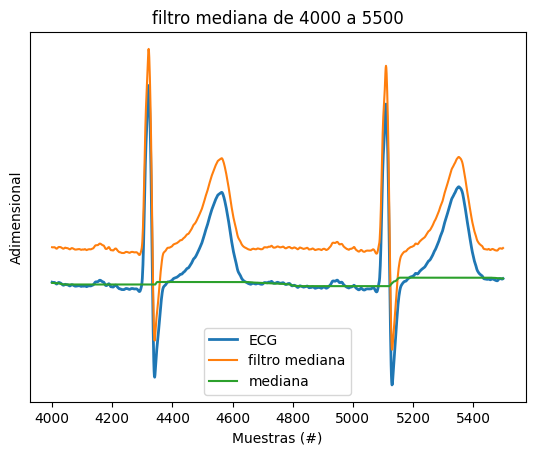

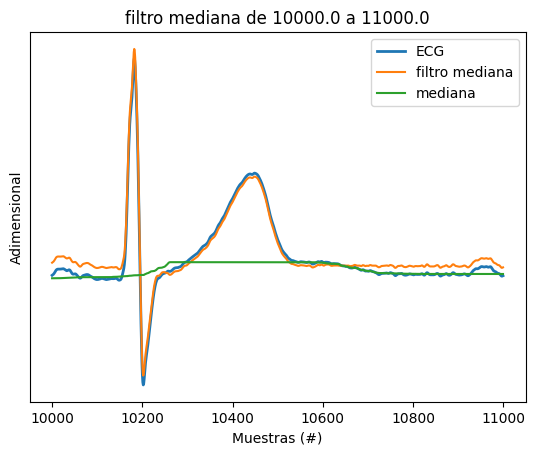

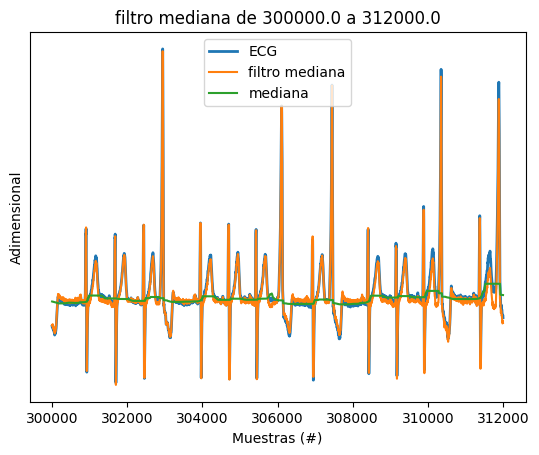

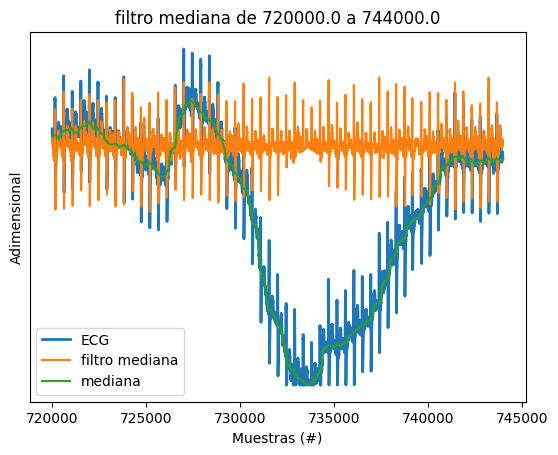

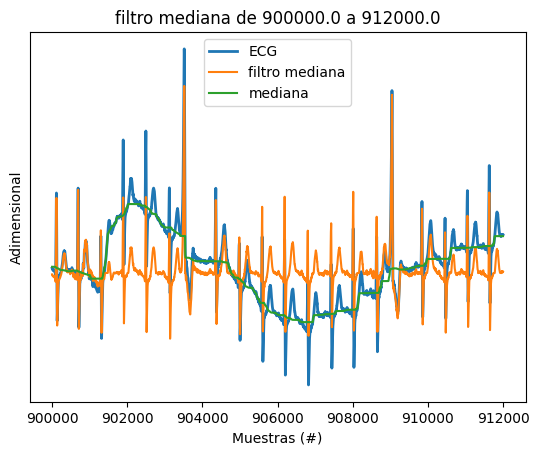

In [9]:
fs = 1000 # Hz

##################
## ECG con ruido
##################

# para listar las variables que hay en el archivo
#sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()
cant_muestras = len(ecg_one_lead)

mediana = signal.medfilt(volume=signal.medfilt(volume=ecg_one_lead, kernel_size=201), kernel_size=601) #kernel size impar para hacer bien la mediana

ecg_mediana = ecg_one_lead - mediana

ecg_real = np.load('ecg_sin_ruido.npy')
###################################
# Regiones de interés con ruido #
###################################

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_mediana[zoom_region ], label='filtro mediana')
    plt.plot(zoom_region, mediana[zoom_region ], label='mediana')
   
    plt.title('filtro mediana de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
# Regiones de interés sin ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_mediana[zoom_region ], label='filtro mediana')
    plt.plot(zoom_region, mediana[zoom_region ], label='mediana')
    plt.title('filtro mediana de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()


Como se observa en los gráficos anteriores, que analizan distintos tramos de la señal ECG, los primeros segmentos presentan menor ruido mientras que los últimos tres muestran interferencias más intensas. En el intervalo comprendido entre las muestras 4000 y 5500, la señal filtrada es casi idéntica a la original, salvo por un desplazamiento vertical debido a que la mediana estimada es cercana a cero. Algo similar ocurre entre 10000 y 11000, donde el movimiento de la línea de base es mínimo.

En cambio, en los tramos 720k–744k y 900k–912k el efecto del filtrado se vuelve más evidente. Allí, al calcular la mediana sobre regiones dominadas por componentes de muy baja frecuencia, el filtro logra seguir más fácilmente la tendencia lenta de la señal y llevarla hacia el eje normalizado.

Si bien el filtro actúa correctamente sobre frecuencias bajas, en presencia de frecuencias altas prácticamente no produce atenuación. Esto puede apreciarse en el ruido presente entre las muestras 4000 y 5500: al utilizar una ventana muy grande en comparación con las oscilaciones rápidas, el operador de mediana no modifica esos componentes. Para filtrar adecuadamente frecuencias altas sería necesario emplear ventanas mucho más pequeñas y densamente muestreadas, lo cual no es adecuado para el propósito de este método.

### Filtro spline

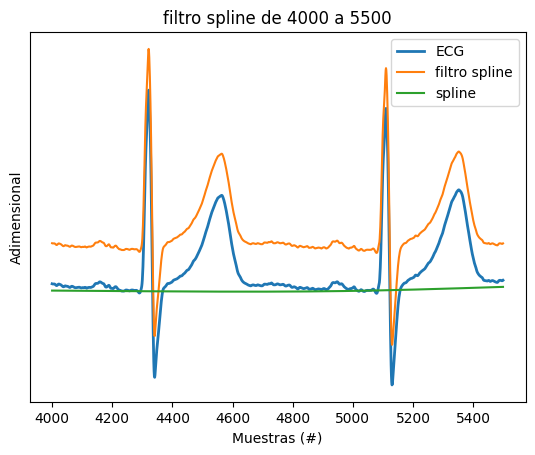

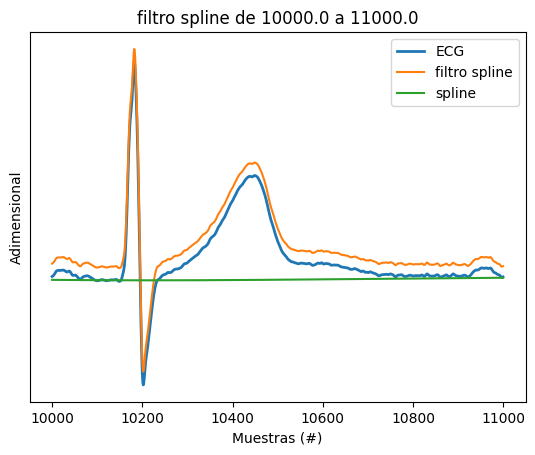

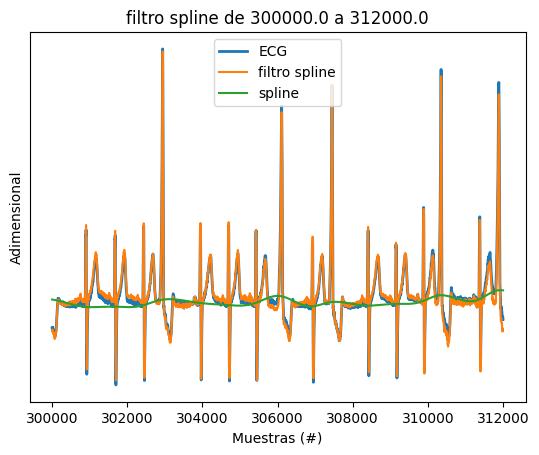

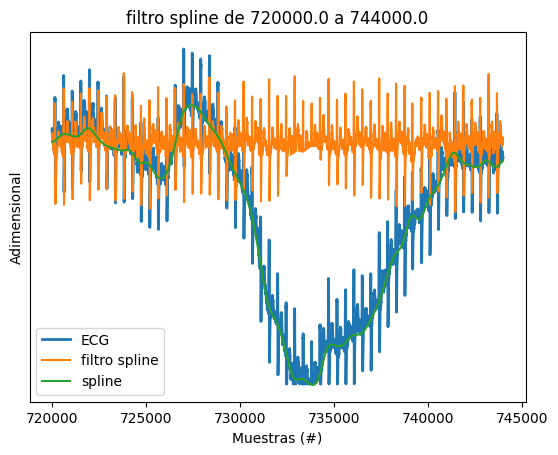

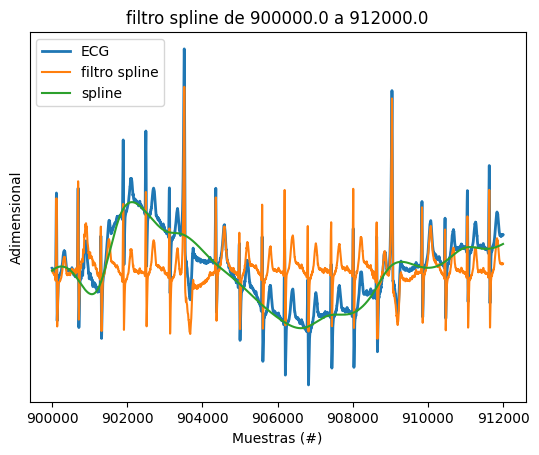

In [10]:
mi= mat_struct['qrs_detections'].flatten()-86

c=CubicSpline(mi,ecg_one_lead[mi])
cubicspline=c(np.arange(0,cant_muestras))
ecg_spline = ecg_one_lead - cubicspline

###################################
# Regiones de interés con ruido #
###################################

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_spline[zoom_region ], label='filtro spline')
    plt.plot(zoom_region, cubicspline[zoom_region ], label='spline')
    
   
    plt.title('filtro spline de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
# Regiones de interés sin ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_spline[zoom_region ], label='filtro spline')
    plt.plot(zoom_region, cubicspline[zoom_region ], label='spline')
   
    plt.title('filtro spline de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

El filtrado por splines cúbicos presenta un comportamiento similar al filtro de mediana: ambos actúan principalmente sobre componentes de muy baja frecuencia, por lo que las señales resultantes se parecen y muestran una corrección efectiva del movimiento de línea de base. Del mismo modo, ninguno de los dos métodos atenúa adecuadamente el ruido de alta frecuencia, ya que estos componentes no forman parte de la tendencia suave que intentan estimar. En el caso particular del spline, al ser una función suave y continua, puede tener más dificultad para seguir cambios abruptos; como consecuencia, en zonas con pendientes muy pronunciadas o discontinuidades relativas, la señal filtrada puede incluso presentar inversiones o sobreajustes alrededor del eje.

### Filtro Adaptado

Matriz de Confusión:
           Predicho
           Sí    No
Real Sí:  [1902    1]
Real No:  [ 3    - ]

TP: 1902, FP: 3, FN: 1

Métricas:
Precisión: 0.998
Sensibilidad: 0.999
F1-score: 0.999


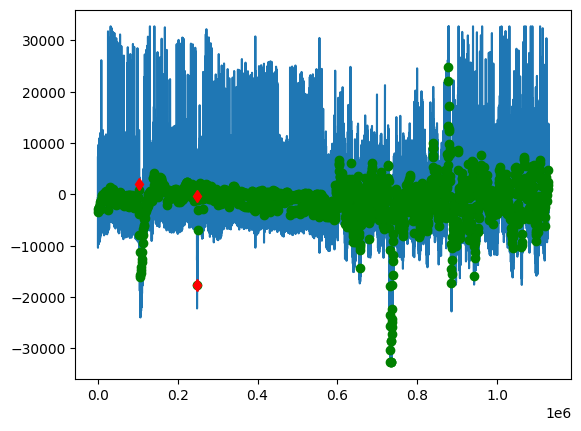

In [4]:
##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Hz

##################
## ECG con ruido
##################

# para listar las variables que hay en el archivo
#sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()
patron = mat_struct['qrs_pattern1'].flatten()-np.mean(mat_struct['qrs_pattern1'].flatten())
qrs_det=mat_struct["qrs_detections"]

ecg_detection=signal.lfilter(b=patron,a=1,x=ecg_one_lead)
ecg_detection=np.abs(ecg_detection)
ecg_detection=ecg_detection/np.std(ecg_detection)

mis_qrs,_=signal.find_peaks(x=ecg_detection,height=1.,distance=300)

# plt.figure()
# plt.plot(ecg_detection/np.std(ecg_detection))
# plt.plot(ecg_one_lead/np.std(ecg_one_lead))
# plt.plot(mis_qrs,ecg_detection[mis_qrs]/np.std(ecg_detection),marker="x",linestyle="")




def matriz_confusion_qrs(mis_qrs, qrs_det, tolerancia_ms=150, fs=1000):
    """
    Calcula matriz de confusión para detecciones QRS usando solo NumPy y SciPy
    
    Parámetros:
    - mis_qrs: array con tiempos de tus detecciones (muestras)
    - qrs_det: array con tiempos de referencia (muestras)  
    - tolerancia_ms: tolerancia en milisegundos (default 150ms)
    - fs: frecuencia de muestreo (default 360 Hz)
    """
    
    # Convertir a arrays numpy
    mis_qrs = np.array(mis_qrs)
    qrs_det = np.array(qrs_det)
    
    # Convertir tolerancia a muestras
    tolerancia_muestras = tolerancia_ms * fs / 1000
    
    # Inicializar contadores
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    
    # Arrays para marcar detecciones ya emparejadas
    mis_qrs_emparejados = np.zeros(len(mis_qrs), dtype=bool)
    qrs_det_emparejados = np.zeros(len(qrs_det), dtype=bool)
    
    # Encontrar True Positives (detecciones que coinciden dentro de la tolerancia)
    for i, det in enumerate(mis_qrs):
        diferencias = np.abs(qrs_det - det)
        min_diff_idx = np.argmin(diferencias)
        min_diff = diferencias[min_diff_idx]
        
        if min_diff <= tolerancia_muestras and not qrs_det_emparejados[min_diff_idx]:
            TP += 1
            mis_qrs_emparejados[i] = True
            qrs_det_emparejados[min_diff_idx] = True
    
    # False Positives (tus detecciones no emparejadas)
    tp_idx=np.where(mis_qrs_emparejados)[0]
    fp_idx=np.where(~mis_qrs_emparejados)[0]
    FP = np.sum(~mis_qrs_emparejados)
    
    # False Negatives (detecciones de referencia no emparejadas)
    fn_idx=np.where(~qrs_det_emparejados)[0]
    fn_idx=fn_idx[0]
    FN = np.sum(~qrs_det_emparejados)
    
    # Construir matriz de confusión
    matriz = np.array([
        [TP, FP],
        [FN, 0]  # TN generalmente no aplica en detección de eventos
    ])
    
    return matriz, TP, FP, FN ,tp_idx, fp_idx, fn_idx 

# Ejemplo de uso

matriz, tp, fp, fn ,tp_idx, fp_idx, fn_idx = matriz_confusion_qrs(mis_qrs, qrs_det)

print("Matriz de Confusión:")
print(f"           Predicho")
print(f"           Sí    No")
print(f"Real Sí:  [{tp:2d}   {fn:2d}]")
print(f"Real No:  [{fp:2d}    - ]")
print(f"\nTP: {tp}, FP: {fp}, FN: {fn}")

# Calcular métricas de performance
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nMétricas:")
print(f"Precisión: {precision:.3f}")
print(f"Sensibilidad: {recall:.3f}")
print(f"F1-score: {f1_score:.3f}")

plt.figure()
plt.plot(ecg_one_lead)
plt.plot(mis_qrs[tp_idx],ecg_one_lead[mis_qrs[tp_idx]],"og",label="TP")
plt.plot(mis_qrs[fp_idx],ecg_one_lead[mis_qrs[fp_idx]],"dr",label="TP")

El filtro adaptado no actúa como un filtro en el sentido tradicional, sino como un detector, reforzando las regiones donde la señal se parece al patrón QRS utilizado. Su implementación se realizó convolucionando el ECG con una plantilla de latido completa y luego detectando los máximos locales mediante findpeaks, usando un intervalo de aproximadamente 300 muestras (un ciclo cardíaco típico). Al comparar estas detecciones con las provistas en ECG_TP4.mat mediante una matriz de confusión, se obtuvo un desempeño muy alto: 1902 latidos correctamente detectados, 3 falsas detecciones negativas y 1 detección falsa positiva.

## Conclusion 
Los filtros no lineales demostraron ser herramientas útiles para la eliminación de componentes de baja frecuencia y para la estimación del movimiento de línea de base en el ECG. Tanto el filtro de mediana como el método basado en splines actúan efectivamente como pasa-bandas implícitos, ya que su comportamiento depende del tamaño de las ventanas o de la separación entre puntos de referencia, lo que limita el rango de frecuencias que pueden atenuar. Debido a su naturaleza no lineal, requieren un conocimiento previo de la señal, como la duración típica del latido o la ubicación del segmento PQ, para funcionar adecuadamente, dificultando su aplicación en tiempo real, a diferencia de los filtros lineales. El filtro adaptado, si bien no es un filtro en el sentido tradicional, permitió detectar con precisión los complejos QRS utilizando una plantilla del latido. Su rendimiento muestra que los métodos no lineales pueden ser muy eficaces cuando se cuenta con información detallada de la morfología cardíaca. 
En resumen , estos resultados evidencian que los filtros no lineales son una alternativa robusta para tareas específicas del procesamiento de ECG, aunque su implementación suele ser más dependiente del contexto y menos apta para sistemas en línea continua.

# Autoevaluación del aprendizaje
Indicar una opción:

Resolví la tarea con seguridad

**Resolví la tarea, pero tengo dudas**

Resolví la tarea,pero no entendí bien

No pude resolverla y no entendí

Responder:

¿Qué aprendiste al hacer esta tarea?



¿Qué te quedó claro? ¿Qué te sigue costando?



**Sí, usé chatGPT, Qwen, Deepseek, Gemini, otra.**

No usé IA.

En caso afirmativo, indicar una opción o varias:

**Escritura**

Código

**Conceptos teorícos**

Gráficos

**Conclusiones**
